### Chapter 6 결정 트리

SVM 처럼 결정 트리(decision tree)는 분류와 회귀 작업 그리고 다중출력 작업도 가능한 다재다능한 알고리즘이다. 또한 매우 복잡한 데이터셋도 학습할 수 있는 강력한 알고리즘이다.

#### 6.1 결정 트리 학습과 시각화

결정 트리를 이해하기 위해 모델 하나를 만들어서 어떻게 예측을 하는지 살펴보겠다.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:]
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

`export_graphviz()` 함수를 사용해 그래프 정의를 `iris_tree.dot` 파일로 출력하여 푼련된 결정 트리를 시각화할 수 있다.

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file = '/content/iris_tree.dot',
    feature_names = iris.feature_names[2:],
    class_names = iris.target_names,
    rounded = True,
    filled = True
)

In [ ]:
!bash

bash: cannot set terminal process group (60): Inappropriate ioctl for device
bash: no job control in this shell
/content# dot -Tpng iris_tree.dot -o iris_tree.png
/content# exit
exit


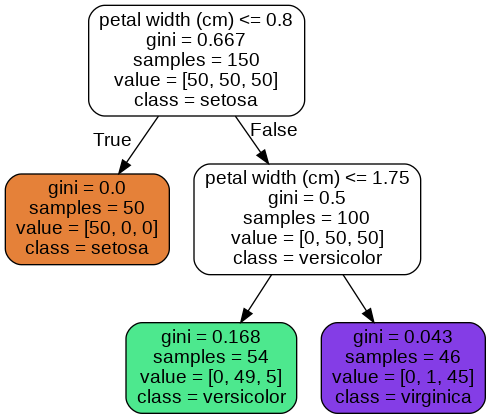

In [ ]:
from IPython import display

display.Image('/content/iris_tree.png')

#### 6.2 예측하기

트리가 어떻게 예측을 만들어내는지 살펴보겠다. 새로 발견한 붓꽃의 품종을 분류하려 한다고 가정하겠다. 먼저 루트 노드에서 시작한다. 이 노드는 petal width 가 0.8cm보다 작은지 판단한다. 만약 그렇다면 왼쪽 노드로 이동하며, 'setosa' 꽃으로 분류된다. 이렇듯 각 노드의 조건에 따라 트리를 내려가며, 마지막 leaf node 까지 도달했을 때, 분류가 완성된다.

위 그림에서 `gini` 속성은 불순도 (impurity)를 측정한다. 한 노드의 모든 샘플이 같은 클래스에 속해 있다면, 이 노드를 순수(gini=0)하다고 한다. 지니 불순도는 아래 공식에 따라 측정할 수 있다.

> G<sub>i</sub> = 1 - sum(*P<sub>i,k</sub><sup>2</sup>*) <br>
* 이 식에서 P<sub>i,k</sub><sup>2</sup>는 i 번째 노드에 있는 훈련 샘플 중, 클래스 k에 속한 샘플의 비율이다.

> 사이킷런은 이진 트리만 만드는 CART 알고리즘을 사용한다. 그러므로 리프 노드 외의 모든 노드는 자식 노드를 두 개씩 가진다. 하지만 ID3 같은 알고리즘은 둘 이상의 자식 노드를 가진 결정 트리를 만들 수 있다.

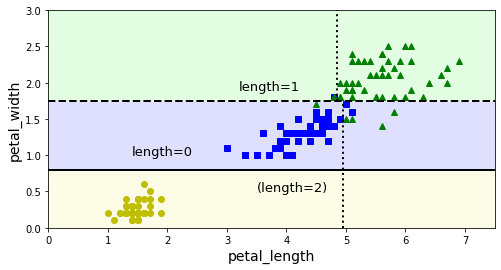

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
  X0, X1 = np.meshgrid(
      np.linspace(axes[0], axes[1], 100),
      np.linspace(axes[2], axes[3], 100)
  )

  X_new = np.c_[X0.ravel(), X1.ravel()]
  y_pred = clf.predict(X_new).reshape(*X0.shape)
  custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
  plt.contourf(X0, X1, y_pred, alpha=0.3, cmap=custom_cmap)
  if not iris:
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(X0, X1, y_pred, cmap=custom_cmap2, alpha=0.8)
  if plot_training:
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
    plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
    plt.axis(axes)
  if iris:
    plt.xlabel("petal_length", fontsize=14)
    plt.ylabel("petal_width", fontsize=14)
  else:
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
  if legend:
    plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "length=0", fontsize=13)
plt.text(3.2, 1.9, "length=1", fontsize=13)
plt.text(3.5, 0.5, "(length=2)", fontsize=13)
plt.show()

> 결정 트리는 직관적이고 결정 방식을 이해하기 쉽다. 이런 모델을 화이트박스 모델이라고 한다. 반대로 앞으로 보게 될 랜덤 포레스트나 신경망은 블랙박스 모델이다.

#### 클래스 확률 추정

결정 트리는 한 샘플이 특정 클래스 k에 속할 확률을 추정할 수도 있다. 먼저 이 샘플에 대해 리프 노드를 찾기 위해 트리를 탐색하고, 그 노드에 있는 클래스 k의 훈련 샘플 비율을 반환한다. 

In [ ]:
tree_clf.predict_proba([[5., 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [ ]:
tree_clf.predict([[5, 1.5]])

array([1])

#### CART 훈련 알고리즘

사이킷런은 결정 트리를 훈련시키기 위해 CART 알고리즘을 사용한다. 먼저 훈련 세트를 하나의 특성 k의 임겠값 t<sub>k</sub>를 사용해 두 개의 서브셋으로 나눈다.
이때 다음 식을 기준으로 가장 순수한 서브셋으로 나눌 수 있는 (k, t<sub>k</sub>) 짝을 찾는다.

> J(k, t<sub>k</sub>) = (m<sub>left</sub> / m) * G<sub>left</sub> + (m<sub>right</sub> / m) * G<sub>right</sub> <br>
* G<sub>left/right</sub>은 왼족/오른쪽 서브셋의 불순도 <br>
* m<sub>left/right</sub>은 왼쪽/오른쪽 서브셋의 샘플 수

CART 알고리즘이 훈련 세트를 성공적으로 둘로 나누었다면 같은 방식으로 서브셋을 또 나누고, 그다음엔 서브셋의 서브셋을 나누고 이런 식으로 계속 반복한다. 이 과정은 최대 깊이가 되면 중지하거나, 불순도를 줄이는 분할을 찾을 수 없을 때 멈추게 된다.

> 여기에서 볼 수 있듯이 CART 알고리즘은 greedy algorithm 이다. 이 알고리즘은 최적의 솔루션을 보장하지는 않지만, 그럭저럭 납득할만한 솔루션을 제시하기는 한다. 불행하게도 최적의 트리를 찾는 것은 NP-완전 문제로, 해결하는데 O(exp(m)) 시간이 필요하고, 매우 작은 훈련 세트에도 적용하기 어렵다. 따라서 greedy algorithm이 적합하다.


#### 6.5 계산 복잡도

예측을 하려면 결정 트리를 루트 노드에서 부터 리프 노드까지 탐색해야 한다. 일반적으로 결정 트리는 거의 균형을 이루고 있으므로, 결정 트리를 탐색하기 위해서는 약 O(log<sub>2</sub>m)개의 노드를 거쳐야 한다. 각 노드는 하나의 특성값만 확인하기 때문에, 예측에 필요한 전체 복잡도는 특성과 무관하게 O(log<sub>2</sub>)이다. 그래서 큰 훈련 세트를 다룰 때도 예측 속도가 매우 빠르다. 

훈련 알고리즘은 각 노드에서 모든 훈련 샘플의 모든 특성을 비교한다. 각 노드에서 모든 샘플의 모든 특성을 비교하면 훈련 복잡도는 O(n * m * log<sub>2</sub>m)이 된다. 훈련 세트가 작을 경우 사이킷런은 (presort=True로 지정하면) 미리 데이터를 정렬하여 훈련 속도를 높일 수 있다.

#### 6.6 지니 불순도 또는 엔트로피

결정트리는 기본적으로 지니 불순도가 사용되지만 `criterion` 매개변수를 'entropy'로 지정하여 엔트로피 불순도를 사용할 수 있다. 식은 다음과 같다.

> H<sub>i</sub> = -sum(p<sub>i,k</sub>log<sub>2</sub>p<sub>i,k</sub>)

지니 불순도와 엔트로피 중 어떤 것을 사용해야 할까. 실제로는 큰 차이가 없다. 즉 둘 다 비슷한 트리를 만들어낸다. 지니 불순도가 조금 더 계산이 빠르기 때문에, 기본값으로 좋다. 그러나, 다른 트리가 만들어지는 경우, 지니 불순도가 가장 빈도 높은 클래스를 한쪽 가지로 고립시키는 경향이 있는 반며느, 엔트로피는 조금 더 균형잡힌 트리를 만든다.

#### 6.7 규제 매개변수

결정 트리는 훈련데이터에 대한 제약 사항이 거의 없다. 제한을 두지 않으면 트리가 훈련 데이터에 아주 가깝게 맞추려고 해서 대부분 과대적합이 되기 쉽다. 결정 트리는 모델 파라미터가 전혀 없는 것이 아니라, 훈련되기 전에 파라미터 수가 결정되지 않기 때문에, 이런 모델을 비파라미터 모델(nonparametric model)이라고 부르곤 한다. 그래서 모델 구조가 데이터에 맞춰져서 고정되지 않고 자유롭다. 반대로 선형 모델 같은 파라미터 모델(parametric model)은 미리 정의된 모델 파라미터 수를 가지므로 자유도가 제한되고 과대적합될 위험이 줄어든다.

훈련데이터에 대한 과대적합을 피하기 위해 학습할 때, 결정 트리의 자유도를 제한할 필요가 있다. 이미 알고 있듯이 이를 규제라고 하는데, 규제 매개변수는 사용하는 알고리즘에 따라 다르지만, 보통 적어도 결정 트리의 최대 깊이는 제어할 수 있다.

> * `max_depth` : 결정트리의 최대 깊이를 결정한다. <br>
* `min_samles_split` : 노드가 분리되기 위해 최소한으로 가지고 있어야 하는 샘플 수 <br>
* `min_samples_leaf` : 리프 노드가 가지고 있어야 할 최소 샘플 수 <br>
* `max_leaf_nodex` : 리프 노드의 최대 수

보통 min_ 으로 시작하는 매개변수를 증가시키거나, max_로 시작하는 매개변수를 감소시키면 모델에 규제가 커진다.

아래 그림은 moons 데이터셋에 훈련시킨 두 개의 결정 트리를 보여준다. 왼쪽 결정 트리는 기본 매개변수를 사용하여 훈련시켰고, 오른쪽 결정 트리는 `min_samples_leaf=4`로 지정하여 훈련시켰다. 외쪽 모델은 확실히 과대적합 된것을 볼 수 있다.

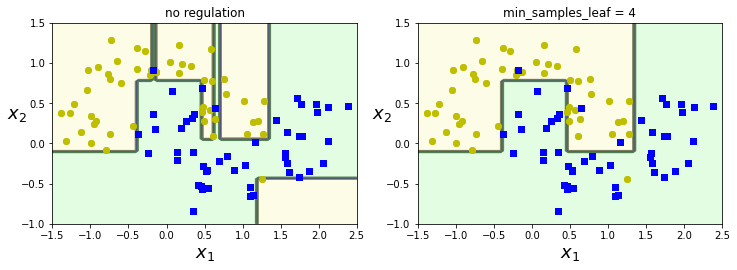

In [ ]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(random_state=42, min_samples_leaf=4)

tree_clf1.fit(Xm, ym)
tree_clf2.fit(Xm, ym)

plt.figure(figsize=(12, 3.7))
plt.subplot(121)
plot_decision_boundary(tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.plot(Xm[ym == 0, 0], Xm[ym == 0, 1], 'yo')
plt.plot(Xm[ym == 1, 0], Xm[ym == 1, 1], 'bs')
plt.title('no regulation')

plt.subplot(122)
plot_decision_boundary(tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.plot(Xm[ym == 0, 0], Xm[ym == 0, 1], 'yo')
plt.plot(Xm[ym == 1, 0], Xm[ym == 1, 1], 'bs')
plt.title('min_samples_leaf = 4')
plt.show()

### 6.8 회귀

결정 트리는 회귀 문제에도 사용할 수 있다. 사이킷런의 `DecisionTreeRegressor`를 사용해 잡음이 섞인 2차 함수 형태의 데이터셋에서 `max_depth=2` 설정으로 회귀 트리를 만들어 보겠다.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# 2차식으로 만든 데이터셋 + 잡음
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_reg,
    out_file = '/content/iris_tree_reg.dot',
    feature_names = ["x1"],
    rounded = True,
    filled = True
)

In [ ]:
!bash

bash: cannot set terminal process group (62): Inappropriate ioctl for device
bash: no job control in this shell
/content# dot -Tpng iris_tree_reg.dot -o iris_tree_reg.png
/content# exit
exit


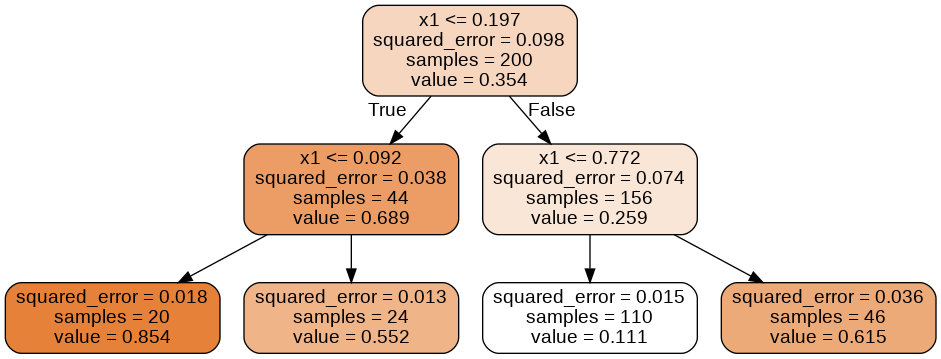

In [ ]:
from IPython import display

display.Image('/content/iris_tree_reg.png')

위 그래프를 보면 앞서 만든 분류 트리와 매우 비슷해 보인다. 주요한 차이는 각 노드에서 클래스를 예측하는 대신, 어떤 값을 예측한다는 점이다. 여기서는 MSE 값이 사용된다.

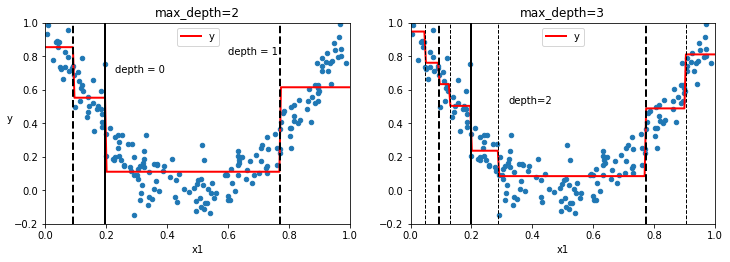

In [ ]:
import matplotlib.pyplot as plt

# max_depth=3 로 새로운 결정트리를 학습시킨다.
tree_reg_3 = DecisionTreeRegressor(max_depth=3)
tree_reg_3.fit(X, y)

X_lin = np.linspace(0., 1., 200).reshape(-1, 1)
y_pred = tree_reg.predict(X_lin)

plt.figure(figsize=(12, 3.7))
plt.subplot(121)
plt.scatter(X, y, s=20)
plt.plot(X_lin, y_pred, 'r-', linewidth=2, label='y')
plt.plot([0.197, 0.197], [-0.2, 1.0], 'k-', linewidth=2)
plt.plot([0.092, 0.092], [-0.2, 1.0], 'k--', linewidth=2)
plt.plot([0.772, 0.772], [-0.2, 1.0], 'k--', linewidth=2)
plt.text(0.23, 0.7, 'depth = 0')
plt.text(0.6, 0.81, 'depth = 1')
plt.xlabel('x1')
plt.ylabel('y', rotation=0)
plt.title('max_depth=2')
plt.axis([0., 1., -0.2, 1.])
plt.legend(loc='upper center')

y_pred_3 = tree_reg_3.predict(X_lin)

plt.subplot(122)
plt.scatter(X, y, s=20)
plt.plot(X_lin, y_pred_3, 'r-', linewidth=2, label='y')
plt.plot([0.197, 0.197], [-0.2, 1.0], 'k-', linewidth=2)
plt.plot([0.092, 0.092], [-0.2, 1.0], 'k--', linewidth=2)
plt.plot([0.772, 0.772], [-0.2, 1.0], 'k--', linewidth=2)
plt.plot([0.046, 0.046], [-0.2, 1.0], 'k--', linewidth=1)
plt.plot([0.13, 0.13], [-0.2, 1.0], 'k--', linewidth=1)
plt.plot([0.287, 0.287], [-0.2, 1.0], 'k--', linewidth=1)
plt.plot([0.904, 0.904], [-0.2, 1.0], 'k--', linewidth=1)
plt.text(0.32, 0.52, 'depth=2')
plt.xlabel('x1')
plt.title('max_depth=3')
plt.axis([0., 1., -0.2, 1.])
plt.legend()
plt.show()

모델의 예측값을 표현하면 위 그림처럼 된다. 각 영역의 예측값은 항상 그 영역에 있는 타깃값의 평균이 된다.

CART 알고리즘은 훈련 세트의 불순도를 최소화하는 방향으로 분할하는 대신, 평균제곱오차를 최소화하도록 분할하는 것을 제외하고는 앞서 설명한 것과 거의 비슷하게 작동한다. 비용함수는 다음과 같다.

> J(k, t<sub>k</sub>) = (m<sub>left</sub> / m) * MSE<sub>left</sub> + (m<sub>right</sub> / m) * MSE<sub>right</sub>

분류에서와 같이, 회귀 작업에서도 결정 트리가 과대적합되기 쉽다. 규제가 없다면, 아래의 왼쪽 그래프와 같이 되기 쉽다. 

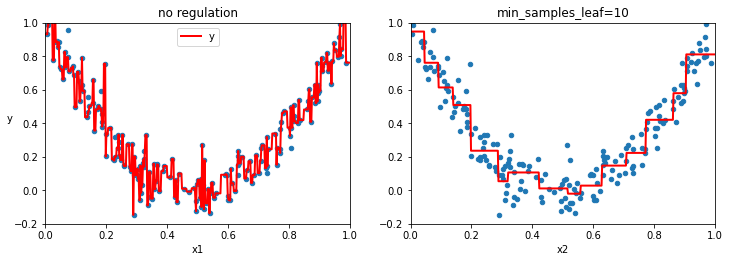

In [ ]:
tree_reg_no = DecisionTreeRegressor(random_state=42)
tree_reg_no.fit(X, y)

tree_reg_yes = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg_yes.fit(X, y)

X_lin = np.linspace(0., 1., 500).reshape(-1, 1)
y_pred_no = tree_reg_no.predict(X_lin)
y_pred_yes = tree_reg_yes.predict(X_lin)

plt.figure(figsize=(12, 3.7))
plt.subplot(121)
plt.scatter(X, y, s=20)
plt.plot(X_lin, y_pred_no, 'r-', linewidth=2, label='y')
plt.legend(loc='upper center')
plt.title('no regulation')
plt.xlabel('x1')
plt.ylabel('y', rotation=0)
plt.axis([0., 1., -0.2, 1.])

plt.subplot(122)
plt.scatter(X, y, s=20)
plt.plot(X_lin, y_pred_yes, 'r-', linewidth=2, label='y')
plt.title('min_samples_leaf=10')
plt.xlabel('x2')
plt.axis([0., 1., -0.2, 1.])
plt.show()

### 6.9 불안정성

결정 트리는 몇가지 제한 사항이 있다. 일단, 결정 트리는 계단 모양의 결정 경계를 만들며, 모든 분할은 축에 수직이다. 따라서 훈련세트의 회전에 민감하다.

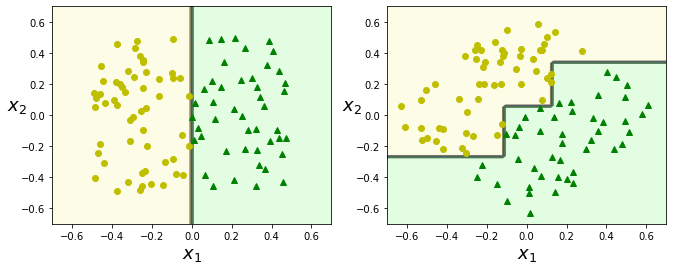

In [ ]:

from sklearn.tree import DecisionTreeClassifier

np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)

tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.show()

위의 그래프를 보면, 왼쪽의 결정 트리는 쉽게 데이터셋을 구분하지만, 데이터를 45도 회전한 오른쪽의 결정 트리는 불필요하게 구분된다. 두 결정 트리 모두 훈련 세트를 완벽하게 학습하지만, 오른쪽 모델은 잘 일반화될 것 같지 않다. 이런 문제를 해결하는 한 가지 방법은 훈련 데이터를 더 좋은 방향으로 회전시키는 PCA 기법을 사용하는 것이다.